In [1]:
import os
from PIL import Image
import torch.nn as nn
import torch
from torchvision import transforms
import numpy as np
from torch.optim import AdamW
from torch.utils.data import Dataset,DataLoader,Subset
from transformers import (
    AutoFeatureExtractor,
    AutoModelForSemanticSegmentation,
    TrainingArguments,
    Trainer,
    SegformerForSemanticSegmentation,
    SegformerImageProcessor
)
from transformers.models.segformer.modeling_segformer import SegformerMLP
import matplotlib.pyplot as plt
import argparse
import torch.nn.functional as F
import random
from sklearn.model_selection import train_test_split

In [2]:
torch.cuda.is_available()

True

In [3]:
class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # BCE
        bce_loss = self.bce(inputs, targets)

        # DICE
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (
            inputs.sum() + targets.sum() + self.smooth
        )

        return bce_loss + dice_loss
def calculate_iou(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds) > threshold
    targets = targets.bool()
    
    intersection = (preds & targets).float().sum((1, 2, 3))
    union = (preds | targets).float().sum((1, 2, 3))
    
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

In [4]:
folder_path = "/home/htic-navigation/SreeVignesh/Knee_Phantom_Dataset/new_dataset_images"
# List all items in the folder
all_items = os.listdir(folder_path)
# Filter only files (ignoring subdirectories)
files = [item for item in all_items if os.path.isfile(os.path.join(folder_path, item))]
print("Number of files:", len(files))
length=len(files)

Number of files: 40


In [3]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b2-finetuned-ade-512-512",num_labels=1,ignore_mismatched_sizes=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
test_length=int(length*0.1)
train_length=length-test_length
data_dir = "/home/htic-navigation/SreeVignesh/Knee_Phantom_Dataset/"
images_dir = os.path.join(data_dir, "new_dataset_images/")
masks_dir = os.path.join(data_dir, "new_dataset_masks/")
image_path = sorted(os.listdir(images_dir))
for i in range(len(image_path)):
    image_path[i]=images_dir+image_path[i]
mask_path = sorted(os.listdir(masks_dir))
for i in range(len(mask_path)):
    mask_path[i]=masks_dir+mask_path[i]
data = list(zip(image_path, mask_path))
random.shuffle(data)

# Split the data
train_data = data[:train_length]
test_data = data[train_length:]

# Debugging output
print(f"Total data: {length}")
print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

Total data: 40
Train data: 36
Test data: 4


In [7]:
train_image=[]
train_mask=[]
val_image=[]
val_mask=[]
for i in train_data:
    train_image.append(i[0])
    train_mask.append(i[1])
for i in test_data:
    val_image.append(i[0])
    val_mask.append(i[1])

In [8]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment

        # Resize and ToTensor are always applied
        self.base_transform = transforms.Compose([
            transforms.Resize((512, 512)),
        ])

        self.image_only_augment = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ])

        # ToTensor is applied after all transforms
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Resize both
        image = self.base_transform(image)
        mask = self.base_transform(mask)

        if self.augment:
            # Apply same random horizontal flip to both image and mask
            if random.random() > 0.5:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)

            # Apply same random rotation
            angle = random.uniform(-20, 20)
            image = transforms.functional.rotate(image, angle)
            mask = transforms.functional.rotate(mask, angle)

            # Apply image-only color jitter
            image = self.image_only_augment(image)

        image = self.to_tensor(image)
        mask = self.to_tensor(mask)

        return image, mask

In [9]:
train_dataset=SegmentationDataset(train_image,train_mask)
val_dataset=SegmentationDataset(val_image,val_mask)

In [10]:
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss()
  # For segmentation, CrossEntropy is common
# 5. Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [13]:
num_epochs = 50
loss_arr=[]
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        logits = outputs.logits  # Segmentation logits (raw predictions)
        upsampled_output = F.interpolate(logits, size=(512, 512), mode='bilinear', align_corners=False)
        # Compute loss (assuming masks are already in the correct format for segmentation)
        loss = criterion(upsampled_output, masks)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    loss_arr.append(avg_loss)
    model.eval()
    iou_scores = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs=outputs.logits
            upsampled_output = F.interpolate(outputs, size=(512, 512), mode='bilinear', align_corners=False)
            iou = calculate_iou(upsampled_output, targets)
            iou_scores.append(iou)

    mean_iou = sum(iou_scores) / len(iou_scores)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss (Training): {avg_loss}")
    print(f"Mean IoU on Test Set: {mean_iou:.4f}")

Epoch [1/50], Average Loss (Training): 1.500699069764879
Mean IoU on Test Set: 0.3719
Epoch [2/50], Average Loss (Training): 1.3764605124791462
Mean IoU on Test Set: 0.4822
Epoch [3/50], Average Loss (Training): 1.265632430712382
Mean IoU on Test Set: 0.5682
Epoch [4/50], Average Loss (Training): 1.1575805611080594
Mean IoU on Test Set: 0.6188
Epoch [5/50], Average Loss (Training): 1.087972429063585
Mean IoU on Test Set: 0.6268
Epoch [6/50], Average Loss (Training): 1.0235268274943035
Mean IoU on Test Set: 0.6985
Epoch [7/50], Average Loss (Training): 0.9675262173016866
Mean IoU on Test Set: 0.7487
Epoch [8/50], Average Loss (Training): 0.9168966677453783
Mean IoU on Test Set: 0.7307
Epoch [9/50], Average Loss (Training): 0.8741717603471544
Mean IoU on Test Set: 0.7152
Epoch [10/50], Average Loss (Training): 0.8262898855739169
Mean IoU on Test Set: 0.7594
Epoch [11/50], Average Loss (Training): 0.7812985380490621
Mean IoU on Test Set: 0.7827
Epoch [12/50], Average Loss (Training): 0.74

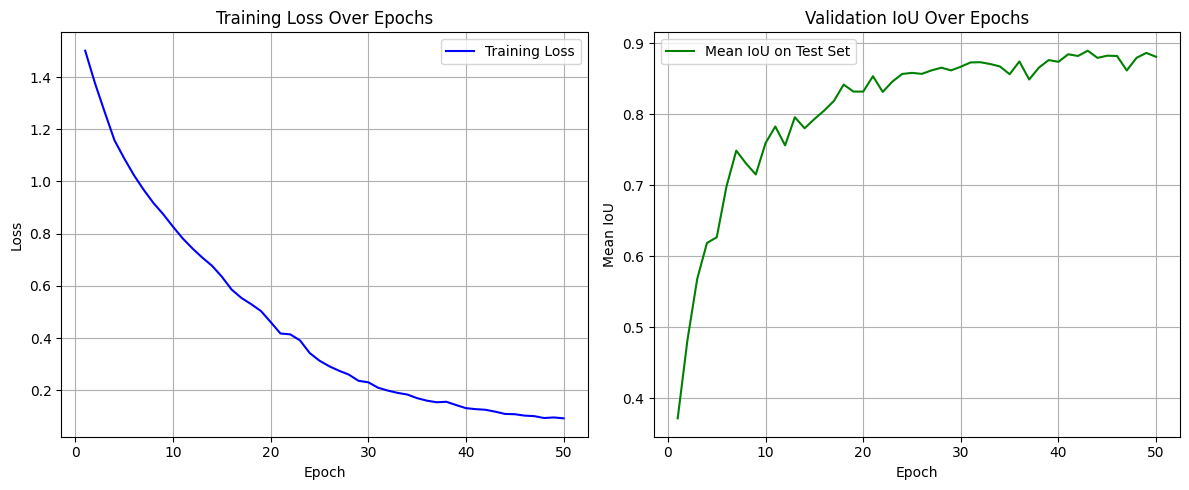

In [5]:
import matplotlib.pyplot as plt

# Training loss for each epoch
training_loss = [
    1.5007, 1.3765, 1.2656, 1.1576, 1.0880, 1.0235, 0.9675, 0.9169, 0.8742, 0.8263,
    0.7813, 0.7429, 0.7082, 0.6768, 0.6349, 0.5859, 0.5538, 0.5301, 0.5038, 0.4613,
    0.4176, 0.4144, 0.3913, 0.3427, 0.3135, 0.2921, 0.2751, 0.2603, 0.2364, 0.2308,
    0.2099, 0.1990, 0.1902, 0.1838, 0.1700, 0.1604, 0.1543, 0.1561, 0.1435, 0.1317,
    0.1279, 0.1255, 0.1183, 0.1096, 0.1085, 0.1032, 0.1011, 0.0939, 0.0961, 0.0927
]

# Mean IoU on test set for each epoch
mean_iou = [
    0.3719, 0.4822, 0.5682, 0.6188, 0.6268, 0.6985, 0.7487, 0.7307, 0.7152, 0.7594,
    0.7827, 0.7562, 0.7958, 0.7802, 0.7932, 0.8051, 0.8187, 0.8417, 0.8319, 0.8318,
    0.8535, 0.8314, 0.8461, 0.8567, 0.8582, 0.8568, 0.8617, 0.8655, 0.8617, 0.8669,
    0.8729, 0.8732, 0.8707, 0.8673, 0.8563, 0.8743, 0.8489, 0.8656, 0.8762, 0.8738,
    0.8844, 0.8820, 0.8894, 0.8793, 0.8824, 0.8820, 0.8616, 0.8794, 0.8863, 0.8808
]

epochs = list(range(1, 51))

# Plot training loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, color='blue', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# Plot mean IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_iou, color='green', label='Mean IoU on Test Set')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.title('Validation IoU Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


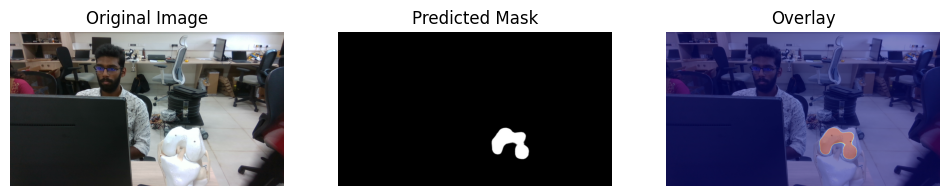

In [7]:
resize_transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize to 512x512
        transforms.ToTensor()])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/home/htic-navigation/SreeVignesh/Built_Models/segformer_50epochs_bcd_dice_b2_new.torch"))
model.to(device)
image_path = "/home/htic-navigation/SreeVignesh/RealSense_Files/test_data/test_0013.png"  # /home/htic-navigation/SreeVignesh/RealSense_Files/test_data/test_0003.png Replace with your image path 
image = Image.open(image_path).convert('RGB')
input_tensor = resize_transform(image).unsqueeze(0).to(device) # Add batch dimension (1, C, H, W)

model.eval()
with torch.no_grad():
    outputs = model(input_tensor)

logits = outputs.logits 
upsampled_output = F.interpolate(logits, size=(512, 512), mode='bilinear', align_corners=True)

binary_mask = upsampled_output.squeeze().cpu().numpy()  # Shape: [512, 512]
binary_mask=binary_mask*255
m=Image.fromarray(binary_mask).convert('L')
binary_mask = m.resize((1280,720), Image.LANCZOS)
# Plot the original image and the predicted mask
fig, axes = plt.subplots(1, 3, figsize=(12, 10))

# Plot original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Plot the predicted mask
axes[1].imshow(binary_mask, cmap='gray')  # Use 'gray' colormap for binary mask
axes[1].set_title("Predicted Mask")
axes[1].axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(binary_mask, alpha=0.5, cmap='jet')
plt.title("Overlay")
plt.axis("off")

plt.show()

In [15]:
torch.save(model.state_dict(), "segformer_50epochs_bcd_dice_b2_new.torch")